# Regression: Cardiovascular Disease Prediction

The purpose of this notebook is to analyse the [Cardiovascular Study Dataset](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea) and create a logistic regression model predicting the 10-year risk of coronary heart disease (CHD).

The structure is roughly as follows:
1. Data loading and cleaning
2. EDA
3. Modelling

In [142]:
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    fbeta_score,
    roc_auc_score,
    roc_curve
)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


## Data Loading and Cleaning

### Loading

In [143]:
df = pd.read_csv("datasets/train.csv", index_col=False)
df.shape


(3390, 17)

### Cleaning

Going through column descriptions on Kaggle, I've decided which columns I will not use in this analysis. They can be removed.
- id; apparenly unique person idenified - irrelevant for obejctive
- education 
    - no description in dataset source - could be anything
    - not a direct marker of health - opposed to rest of features

In [144]:
def remove_cols(df:pd.DataFrame, col_list: List):
     """ Creation f-ion to remove columns"""
     df0 = df.drop(col_list)
     return df

In [145]:
remove_columns = [
    "id",
    "education"
]

In [146]:
df = df.drop(columns=remove_columns)

Let's look at a sample of data and see if I notice anything suspicious.

In [147]:
df.head(5)

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


we can see there are continuos and categorical values. let us prepare them.
- is_smoking is YES/NO instead of 1/0;
- sex category has Male/Female instead of 1/0;

In [148]:
df = pd.get_dummies(df, columns=['sex'], drop_first=True)
df['is_smoking'] = df['is_smoking'].map({'NO': 0, 'YES': 1})

cont_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose']
cat_cols = ['BPMeds', 'is_smoking', 'prevalentStroke', 'prevalentHyp', 'diabetes']

Ensuring no rows with null values in TenYearCHD remain

In [149]:
df.shape

(3390, 15)

In [150]:
df = df.dropna(subset=["TenYearCHD"])
df.shape

(3390, 15)

Checking for NULLs in whole dataset

In [151]:
df.isna().mean().sort_values(ascending=False)

glucose            0.089676
BPMeds             0.012979
totChol            0.011209
cigsPerDay         0.006490
BMI                0.004130
heartRate          0.000295
age                0.000000
is_smoking         0.000000
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
sysBP              0.000000
diaBP              0.000000
TenYearCHD         0.000000
sex_M              0.000000
dtype: float64

Glucose has highest number of NaNs at 9%, others are almost full (<1.29%)

BPMeds             0.012979
totChol            0.011209
cigsPerDay         0.006490
BMI                0.004130
heartRate          0.000295

Lets inspect numeric features to see if there are any more issues.

In [152]:
df.describe().round(2)


,age,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.00,3390.0,3368.00,3346.00,3390.00,3390.00,3390.00,3352.00,3390.00,3390.00,3376.00,3389.00,3086.00,3390.00
mean,49.54,0.5,9.07,0.03,0.01,0.32,0.03,237.07,132.60,82.88,25.79,75.98,82.09,0.15
std,8.59,0.5,11.88,0.17,0.08,0.46,0.16,45.25,22.29,12.02,4.12,11.97,24.24,0.36
min,32.00,0.0,0.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.96,45.00,40.00,0.00
25%,42.00,0.0,0.00,0.00,0.00,0.00,0.00,206.00,117.00,74.50,23.02,68.00,71.00,0.00
50%,49.00,0.0,0.00,0.00,0.00,0.00,0.00,234.00,128.50,82.00,25.38,75.00,78.00,0.00
75%,56.00,1.0,20.00,0.00,0.00,1.00,0.00,264.00,144.00,90.00,28.04,83.00,87.00,0.00
max,70.00,1.0,70.00,1.00,1.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


All values appear plausible and within medically possible ranges. No obvious anomalies are evident from the summary statistics.

That concludes the data loading and cleaning step. We have a dataframe with around 3.4k rows.


## Exploratory Data Analysis

#### General
First lets look at the dependent variable in this analysis, TenYearCHD.

[Text(0, 0, '2879'), Text(0, 0, '511')]

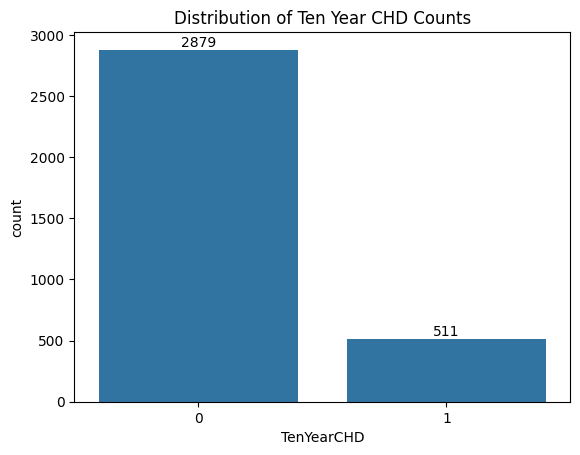

In [153]:
ax = sns.countplot(x=df["TenYearCHD"])
ax.set_title("Distribution of Ten Year CHD Counts")
ax.bar_label(ax.containers[0])

We can see the dataset is heavily skewed - the majority class (1) has 2,879 samples, while the minority class (0) has 511 samples. To handle this, will be used:
1.  a stratified split to maintain class proportions in train and test sets;
2.	class weights in the logistic regression to account for the imbalance.

##### Correlations
Let's have a look at correlations:

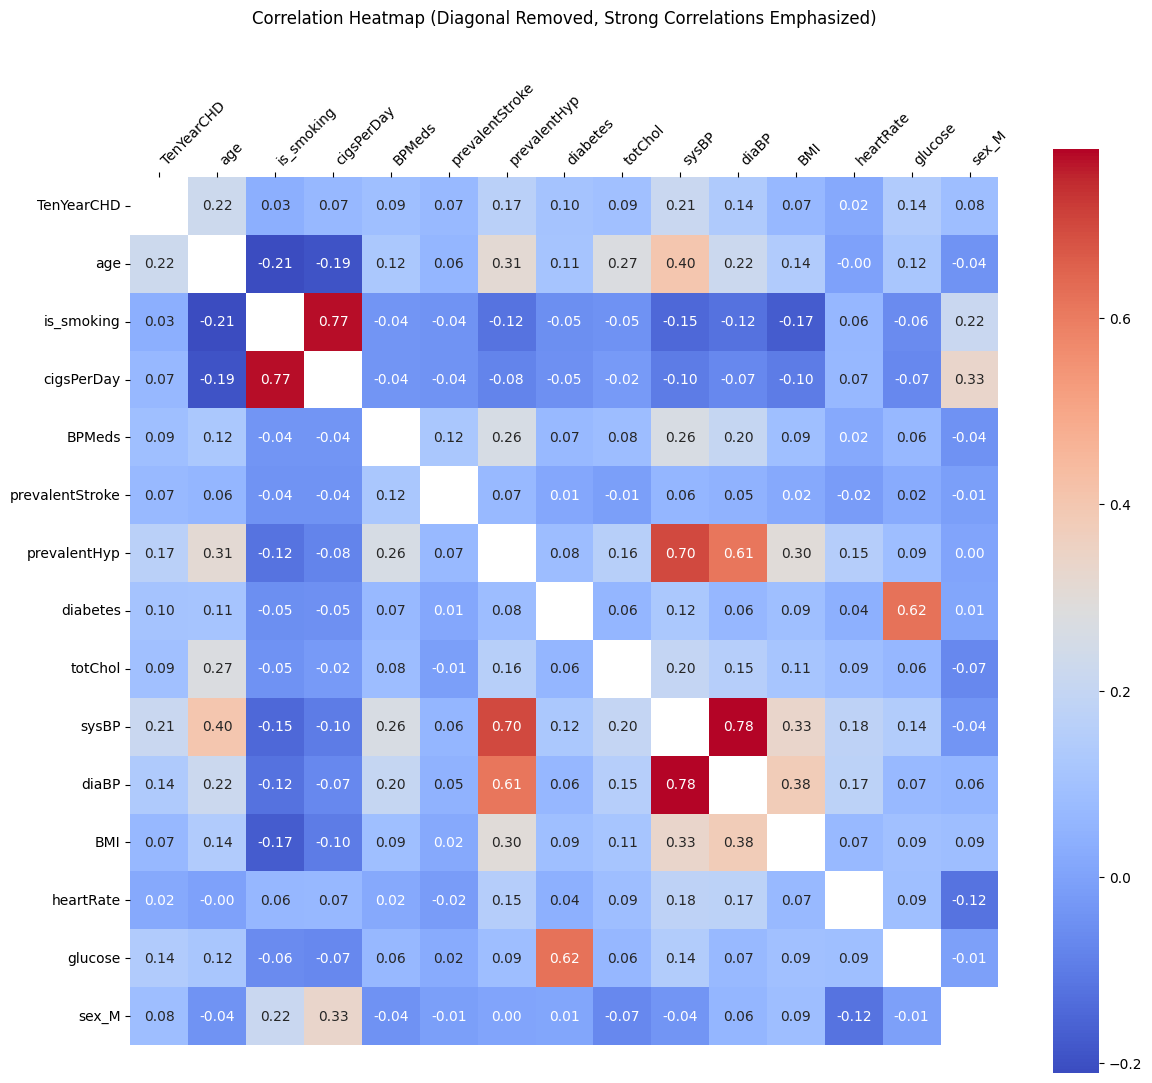

In [154]:
cols = ['TenYearCHD'] + [c for c in df.columns if c != 'TenYearCHD']
df = df[cols]

corr = df.corr()
mask = corr.eq(1.0)

plt.figure(figsize=(14, 12))
ax = sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    mask=mask
)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left')
plt.title('Correlation Heatmap (Diagonal Removed, Strong Correlations Emphasized)', pad=40)
plt.show()

We can see some strong correlations:
- is_smoking and cigsPerDay - 0.77
- sysBP and diaBP - 0.78
- sysBP and prevalentHyp - 0.70
- glucose and diabetes - 0.62

Actions in modeling phase:
1. drop is_smoking
2. drop diaBP
3. drop prevalentHyp
4. consider diabetes feature when imputing missing values for glucose

#### Continuos features

##### Box-plots
Let's see box plots of continuos features

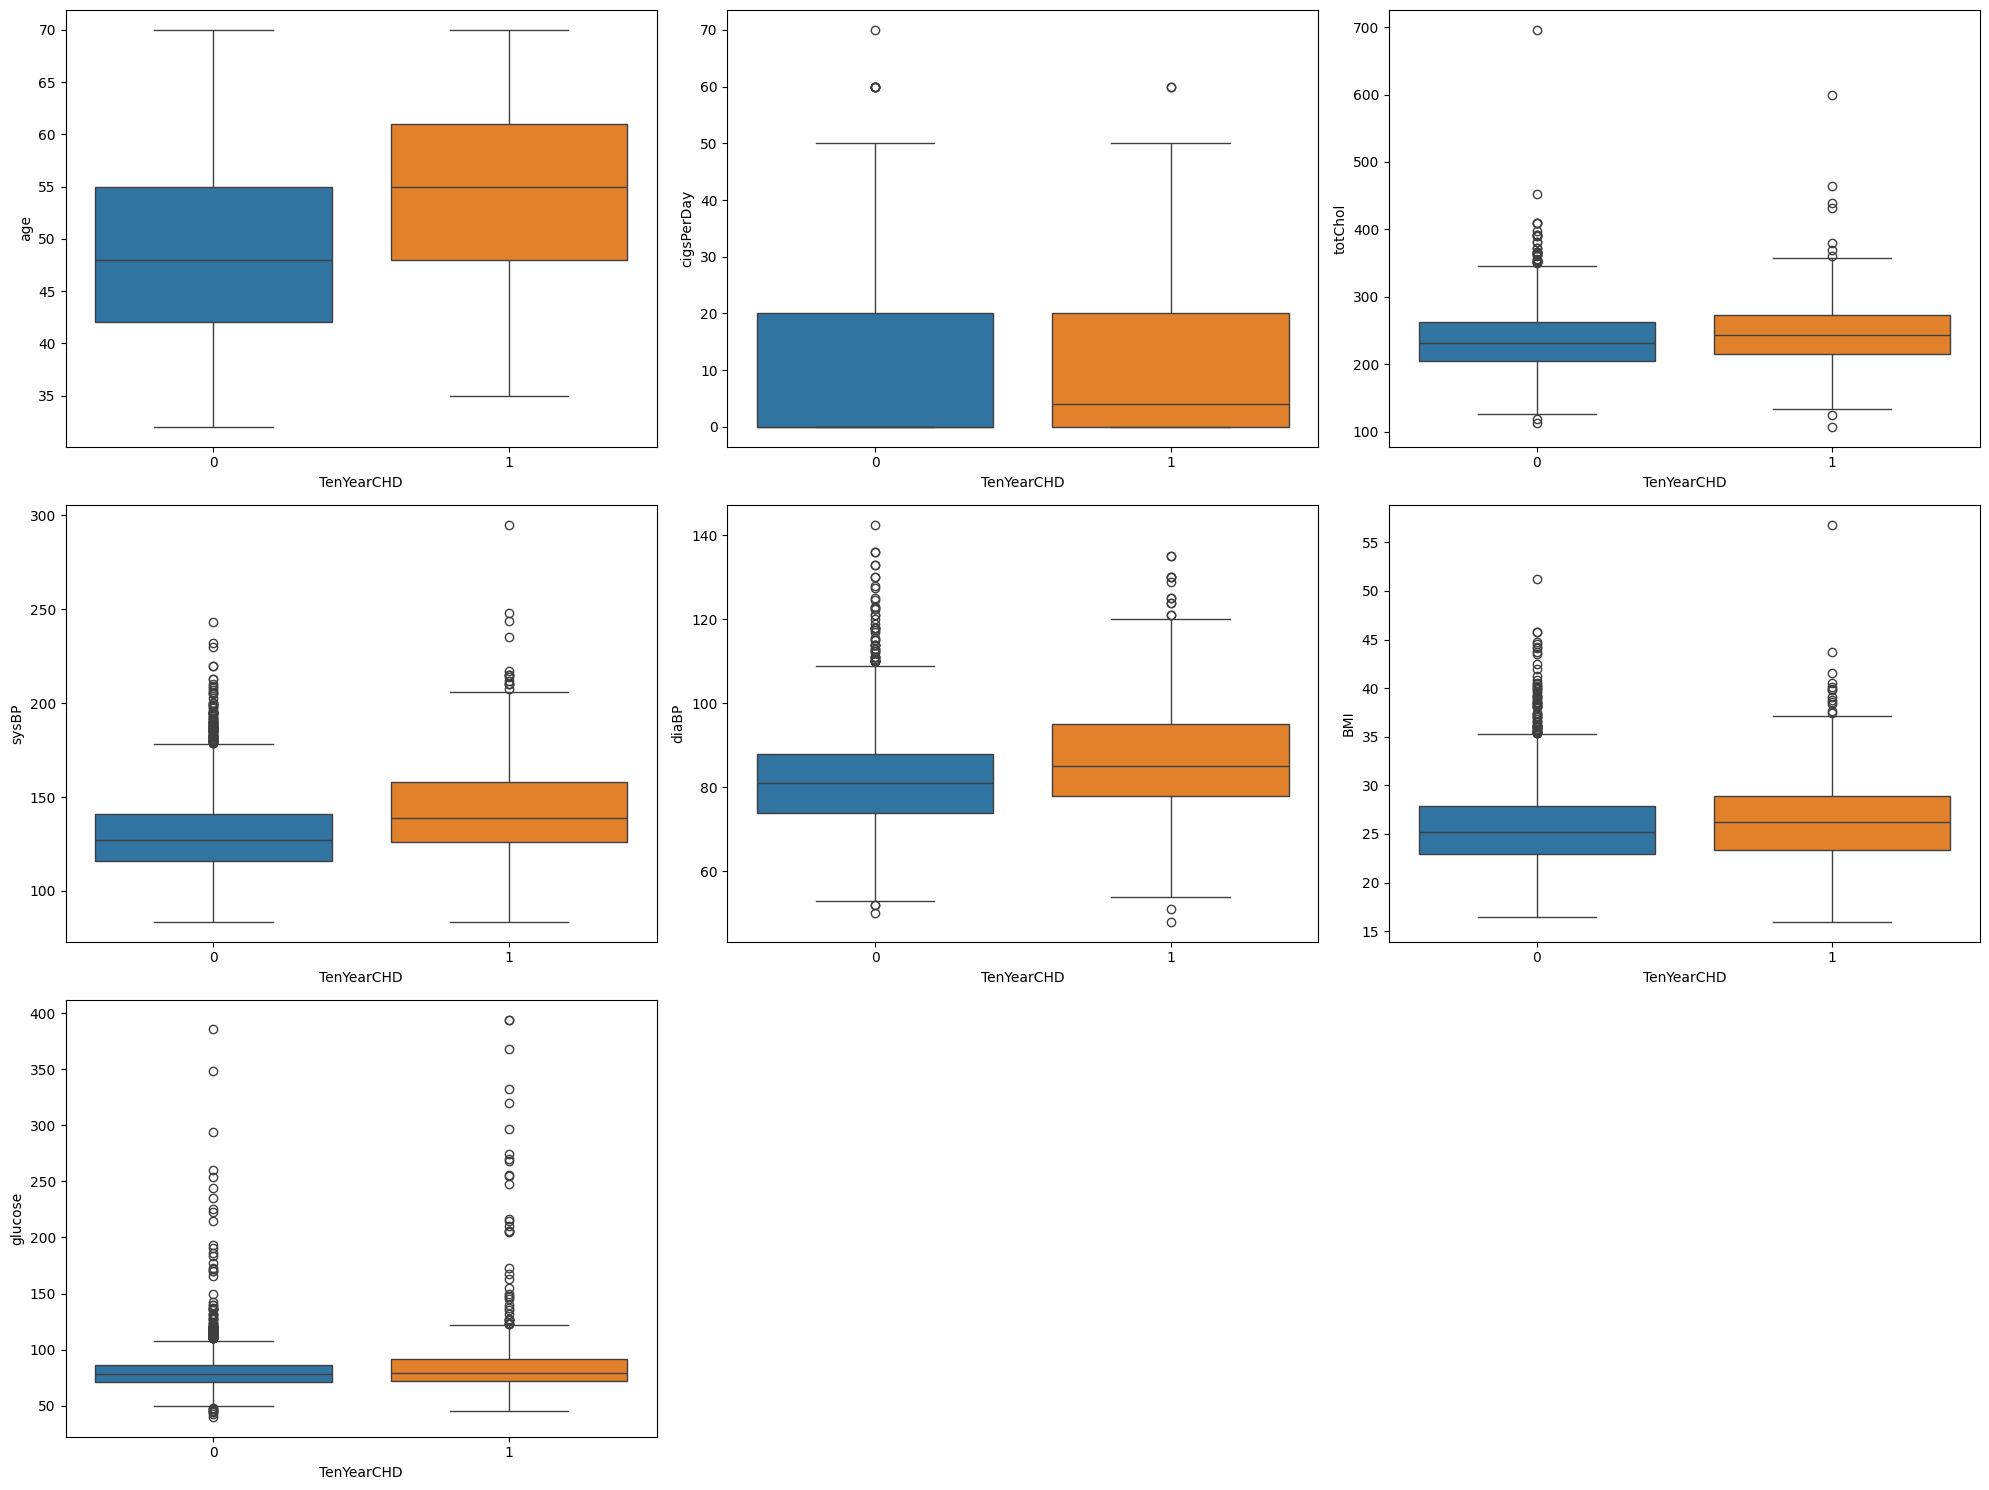

In [155]:
n = len(cont_cols)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()
for i, col in enumerate(cont_cols):
    sns.boxplot(x='TenYearCHD', y=df[col], data=df, ax=axes[i], hue='TenYearCHD', legend=False)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

All featurs but age contain outliers

##### Histograms
Let's check histograms of continuos features

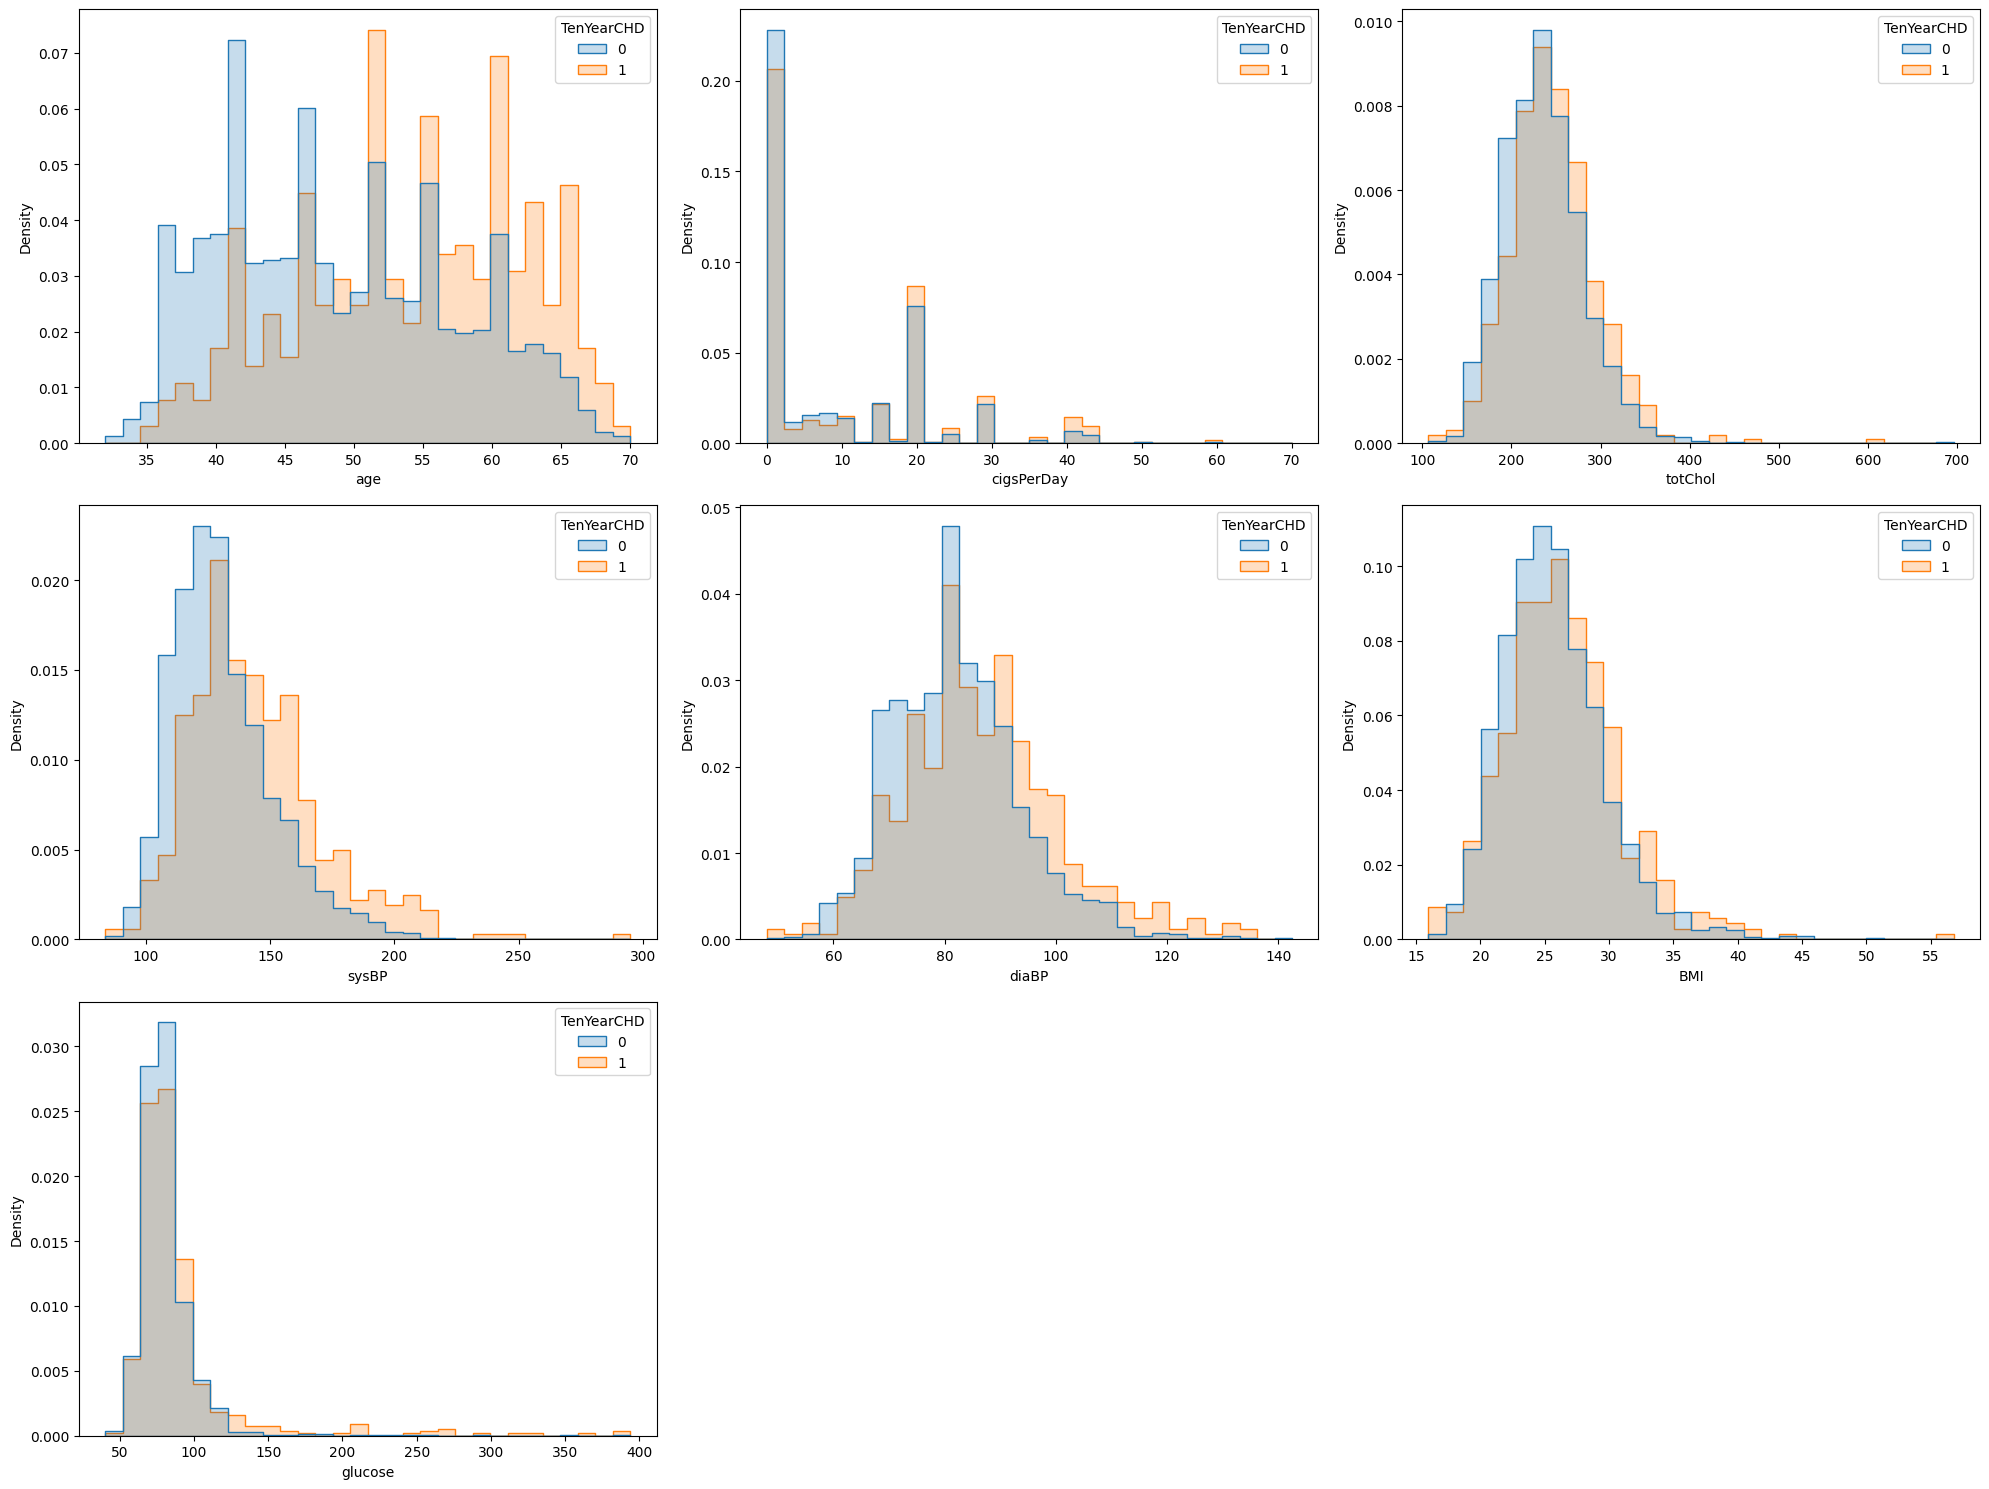

In [156]:
n = len(cont_cols)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(cont_cols):
    sns.histplot(
        data=df,
        x=col,
        hue='TenYearCHD',
        ax=axes[i],
        bins=30,
        element='step',
        stat='density',
        common_norm=False
    )

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

##### Age
Age is out highest correlator (22%) and histogram looks very spiky. Let's have a look with bucket size of 1 year.

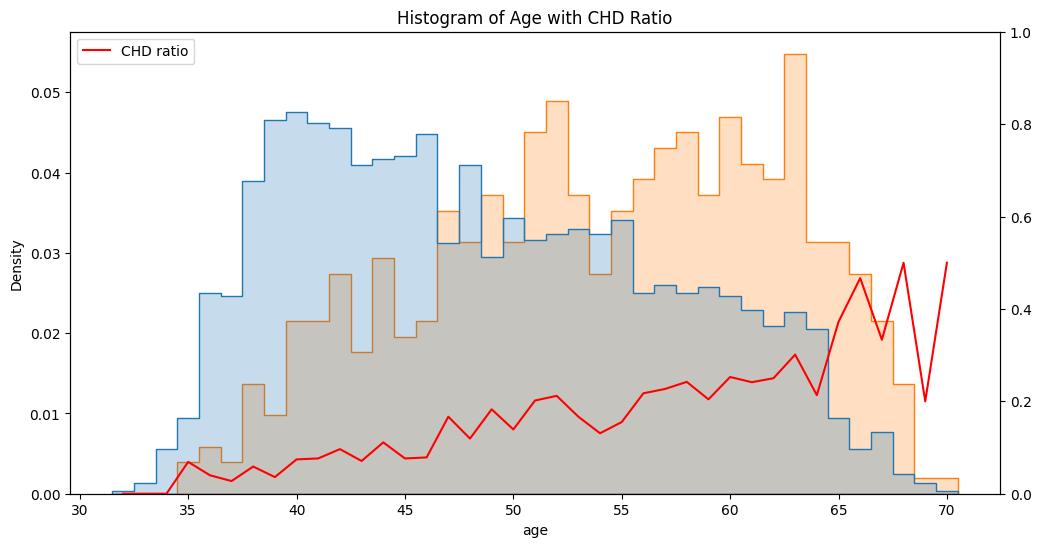

In [157]:
fig, ax1 = plt.subplots(figsize=(12, 6))

bins = np.arange(df.age.min(), df.age.max() + 2) - 0.5
sns.histplot(df, x='age', hue='TenYearCHD', bins=bins,
             element='step', stat='density', common_norm=False, ax=ax1)

ax1.set_title('Histogram of Age with CHD Ratio')

ax2 = ax1.twinx()

age_range = range(int(df.age.min()), int(df.age.max()) + 1)
ratios = [df[df.age == a].TenYearCHD.mean() for a in age_range]

ax2.plot(age_range, ratios, color='red', linestyle='-', label='CHD ratio')
ax2.set_ylim(0, 1)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.show()

A gradual increase with a sharper incline at 65 year mark can be observed

Overlappind histogram does not allow to justify distribution normality. Let's verify

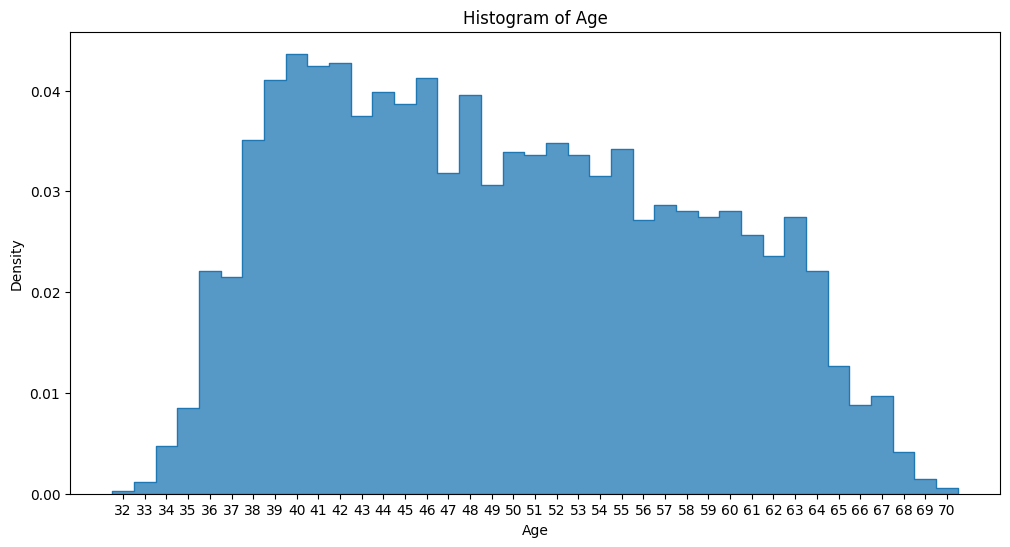

In [158]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x='age',
    bins=np.arange(df['age'].min(), df['age'].max() + 2) - 0.5,
    element='step',
    stat='density'
)
plt.xticks(range(int(df['age'].min()), int(df['age'].max()) + 1))
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Histogram of Age')
plt.show()

Looks lightly skewed to the left.

##### Skewness
Noticed some metrics appear skewed. Let's assess where skewness:

In [159]:
skewness = df[cont_cols].skew().sort_values(ascending=False)
skewness


glucose       6.144390
cigsPerDay    1.223005
sysBP         1.175837
BMI           1.022252
totChol       0.940636
diaBP         0.718173
age           0.225796
dtype: float64

Let's see where skewness is high

In [160]:
highly_skewed = skewness[skewness.abs() >= 1]
highly_skewed

glucose       6.144390
cigsPerDay    1.223005
sysBP         1.175837
BMI           1.022252
dtype: float64

Feature Skewness and Transformation

Skewness was assessed numerically for continuous variables.

The following features showed strong right skew (|skew| ≥ 1):
- glucose
- cigsPerDay
- sysBP
- BMI

To reduce skew a log transformation was applied to these features.

#### Categorical features

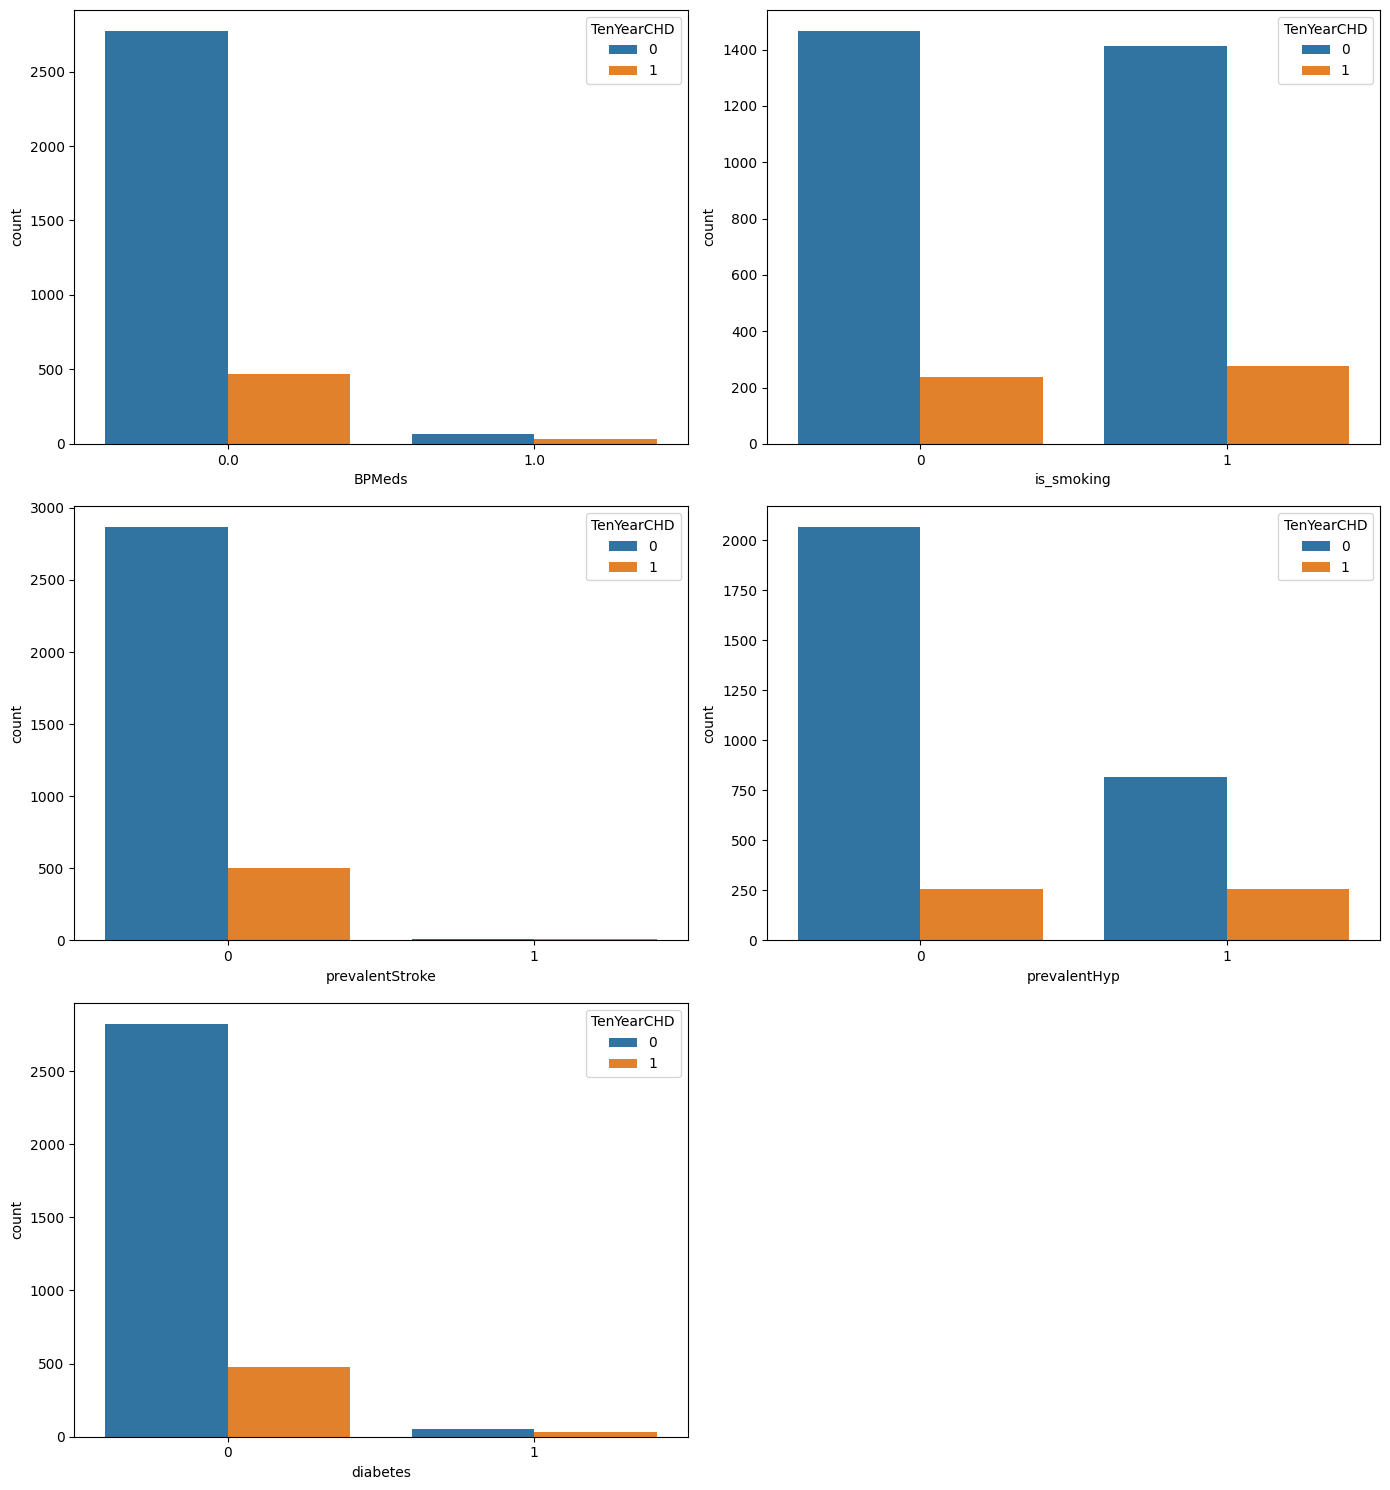

In [161]:
n = len(cat_cols)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(
        data=df,
        x=col,
        hue='TenYearCHD',
        ax=axes[i]
    )

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Stroke flag is outlier here due to absence of positive rows. Our categorical values did not have NULL values, so nothing to fix.

#### Conclusion
This concludes the EDA! During the EDA above, I have made the following decisions before my modelling step:

Actions in modeling phase:
* drop multicolinear features: is_smoking, diaBP, prevalentHyp;
* consider diabetes feature when imputing missing values for glucose
* normalize skewed features with log transformation

## Modelling


### Defining data
Dropping  the multicollinear columns

In [162]:
cont_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'BMI', 'glucose', 'heartRate']
cat_cols = ['prevalentStroke',  'diabetes', 'BPMeds']

y = df["TenYearCHD"]
X = df[cont_cols + cat_cols]

### Splitting data
Splitting data into train and test sets stratified by target metric to account for skewness distribution

In [163]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

In [164]:
#cols_for_log_transformation = highly_skewed.tolist

log_cols = ['glucose', 'cigsPerDay', 'sysBP', 'BMI']

for col in log_cols:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

### Fixing NaN values

Fixing glucose NaNs by imputing median based on a highly correlated (0.62) diabetes flag

In [165]:
# Impute glucose based on diabetes flag
glucose_missing = X_train['glucose'].isna()

median_glucose_diabetes = X_train.loc[X_train['diabetes'] == 1, 'glucose'].median()
median_glucose_no_diabetes = X_train.loc[X_train['diabetes'] == 0, 'glucose'].median()
median_glucose_overall = X_train['glucose'].median()

X_train.loc[glucose_missing & (X_train['diabetes'] == 1), 'glucose'] = median_glucose_diabetes
X_train.loc[glucose_missing & (X_train['diabetes'] == 0), 'glucose'] = median_glucose_no_diabetes
X_train.loc[glucose_missing & (X_train['diabetes'].isna()), 'glucose'] = median_glucose_overall

# Median imputation for other continuous columns
for col in ['BPMeds', 'totChol', 'cigsPerDay', 'BMI', 'heartRate']:
    X_train[col].fillna(X_train[col].median(), inplace=True)

applyng same for test

In [166]:
glucose_missing_test = X_test['glucose'].isna()
X_test.loc[glucose_missing_test & (X_test['diabetes'] == 1), 'glucose'] = median_glucose_diabetes
X_test.loc[glucose_missing_test & (X_test['diabetes'] == 0), 'glucose'] = median_glucose_no_diabetes
X_test.loc[glucose_missing_test & (X_test['diabetes'].isna()), 'glucose'] = median_glucose_overall

for col in ['BPMeds', 'totChol', 'cigsPerDay', 'BMI', 'heartRate']:
    X_test[col] = X_test[col].fillna(X_train[col].median())

### Fixing skewed features

### Creating model

In [167]:
model = LogisticRegression(max_iter=10000, class_weight='balanced')
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

### Treshold setting

Since we are predicting a serious illness, missing a positive case (false negative) is more costly than a false alarm (false positive). F2 score weighs recall higher than precision, making it more appropriate than F1 or accuracy for selecting the optimal threshold in this context.

/Users/augustinas/GitHub/TC Projects/acobot-PYDA.4.4/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/augustinas/GitHub/TC Projects/acobot-PYDA.4.4/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


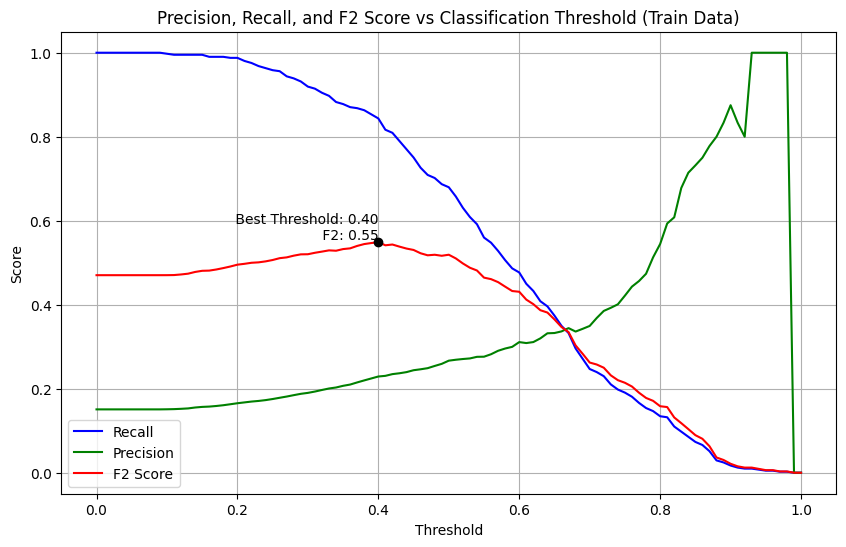

In [168]:
y_train_proba = model.predict_proba(X_train)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []
precisions = []
f2_scores = []

for t in thresholds:
    y_pred_thresh = (y_train_proba >= t).astype(int)
    recalls.append(recall_score(y_train, y_pred_thresh))
    precisions.append(precision_score(y_train, y_pred_thresh))
    f2_scores.append(fbeta_score(y_train, y_pred_thresh, beta=2))

best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
best_f2 = f2_scores[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='green')
plt.plot(thresholds, f2_scores, label='F2 Score', color='red')
plt.scatter(best_threshold, best_f2, color='black', zorder=5)
plt.text(best_threshold, best_f2, f' Best Threshold: {best_threshold:.2f}\n F2: {best_f2:.2f}', 
         verticalalignment='bottom', horizontalalignment='right')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F2 Score vs Classification Threshold (Train Data)')
plt.legend()
plt.grid(True)
plt.savefig("images/trehshold.png", dpi=300, bbox_inches="tight")
plt.show()


Checking scores with default treshold

In [169]:
y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f2 = fbeta_score(y_test, y_test_pred, beta=2)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F2 Score: {f2:.3f}")

Precision: 0.260
Recall: 0.637
F2 Score: 0.494


F2 = 0.487 

Let's see with updated

In [170]:
y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f2 = fbeta_score(y_test, y_test_pred, beta=2)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F2 Score: {f2:.3f}")

Precision: 0.220
Recall: 0.804
F2 Score: 0.525


Treshold setting from 0.50 to 0.40 allowed increase of F2 from 0.487 to 0.525

### Performance evaluation

Training set metrics:

In [171]:
y_train_proba = model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= best_threshold).astype(int)

print("recall score", recall_score(y_train, y_train_pred))
print("roc_auc score", roc_auc_score(y_train, y_train_proba))
print("f2 score", fbeta_score(y_train, y_train_pred, beta=2))

recall score 0.843520782396088
roc_auc score 0.7292274242059098
f2 score 0.549013367281986


Test set metrics

In [172]:
y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("recall score", recall_score(y_test, y_test_pred))
print("roc_auc score", roc_auc_score(y_test, y_test_proba))
print("f2 score", fbeta_score(y_test, y_test_pred, beta=2))
print('-----------------------------------')

cm = confusion_matrix(y_test, y_test_pred)
labels = ['Actual 0', 'Actual 1']
preds = ['Pred 0', 'Pred 1']

print("confusion matrix")
print(pd.DataFrame(cm, index=labels, columns=preds))
print('-----------------------------------')

print(classification_report(y_test, y_test_pred))

recall score 0.803921568627451
roc_auc score 0.7240264161220042
f2 score 0.5249679897567221
-----------------------------------
confusion matrix
          Pred 0  Pred 1
Actual 0     285     291
Actual 1      20      82
-----------------------------------
              precision    recall  f1-score   support

           0       0.93      0.49      0.65       576
           1       0.22      0.80      0.35       102

    accuracy                           0.54       678
   macro avg       0.58      0.65      0.50       678
weighted avg       0.83      0.54      0.60       678



Creating confusion matrix visualization

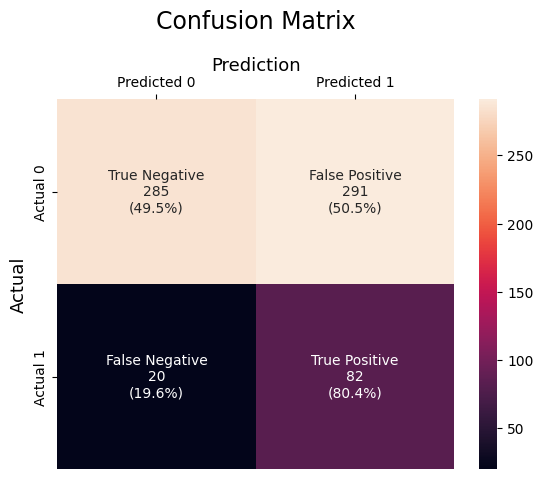

In [173]:
cm = confusion_matrix(y_test, y_test_pred)

row_sums = cm.sum(axis=1, keepdims=True)
cm_perc = cm / row_sums

annot = [
    [
        f"True Negative\n{cm[0,0]}\n({cm_perc[0,0]:.1%})",
        f"False Positive\n{cm[0,1]}\n({cm_perc[0,1]:.1%})"
    ],
    [
        f"False Negative\n{cm[1,0]}\n({cm_perc[1,0]:.1%})",
        f"True Positive\n{cm[1,1]}\n({cm_perc[1,1]:.1%})"
    ]
]

sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1']
)

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.savefig("images/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

Creating ROC (Receiver Operating Characteristic) curve visualization

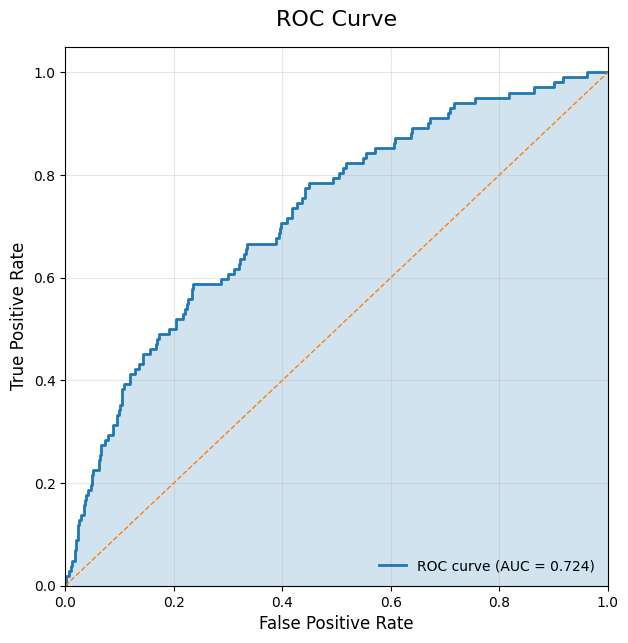

In [174]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.fill_between(fpr, tpr, alpha=0.2)
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=16, pad=15)
plt.legend(loc='lower right', frameon=False)
plt.grid(alpha=0.3)

plt.savefig("images/roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

### Test sample

Having a quick look at test sample

In [175]:
df_test = X_test.copy()
df_test['actual'] = y_test
df_test['predicted'] = y_test_pred
df_test['predicted_probability'] = y_test_proba
df_test.sample(5)

,age,cigsPerDay,totChol,sysBP,BMI,glucose,heartRate,prevalentStroke,diabetes,BPMeds,actual,predicted,predicted_probability
819,53,2.708050,252.0,4.795791,3.097386,4.369448,68.0,0,0,0.0,0,1,0.526851
2542,52,0.000000,263.0,4.894101,3.447445,4.174387,75.0,0,0,0.0,0,0,0.391165
1146,47,3.931826,217.0,4.983607,3.397189,4.330733,82.0,0,0,0.0,0,1,0.593221
1815,40,3.433987,190.0,4.709530,3.243764,4.290459,60.0,0,0,0.0,0,0,0.301372
3316,46,0.000000,304.0,4.886583,3.091951,4.727388,68.0,0,0,0.0,0,0,0.352711


Reviewing whole dataset separetely could unfold patterns, that addressed would improve results

## Conclusions

- **Data Insights:** Age, BMI, and systolic BP show strong correlation with CHD risk. Multicollinear features like `is_smoking` and `diaBP` were removed to improve model stability.  
- **Modeling Decisions:** Logistic Regression with `class_weight='balanced'` was used to handle class imbalance. Skewed features were log-transformed.  
- **Threshold Optimization:** Using F2 score allowed prioritizing recall over precision, which is crucial in predicting CHD to minimize false negatives. The optimal threshold of 0.40 improved F2 from 0.487 to 0.525 on the test set.  
- **Actionable Insight:** Older age, higher BMI, and elevated systolic BP are associated with increased CHD risk. Patients flagged by the model should be prioritized for preventive interventions.

**Linking insights to conclusions:** Each modeling choice and transformation was directly informed by EDA findings. Threshold choice was guided by the medical context, ensuring the model focuses on correctly identifying high-risk patients rather than just maximizing overall accuracy.

### Limitations

- **Data Limitations**
  - **Demographic Features**
    - `CigsPerDay`: Variability in cigarette potency may reduce the reliability of this feature.  
    - `is_smoking`: Definition of a smoker is unclear; ex-smokers are not distinguished.  

  - **Biomarkers**
    - `HeartRate`: Naturally variable and may not be a robust indicator. Metrics like HRV or VO2 max could provide stronger predictive value.  
    - `Diabetes`: Additional details, such as diabetes type, could improve specificity of predictions.  

 

### Next Steps

- Use sklearn pipelines for code quality
- Interpret coefficients ensuring their significance is validated
- Perform a **cost analysis** comparing false positives vs. false negatives to better determine the optimal recall-accuracy tradeoff.  
- Conduct **EDA on misclassified cases** to identify patterns and potential feature improvements.